In [1]:
import os
import sys

spark_home = os.environ['SPARK_HOME']
print spark_home
sys.path.insert(0, spark_home + "/python/")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

# Initialize PySpark to predefine the SparkContext variable 'sc'
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

/home/taddy/lib/spark
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0-SNAPSHOT
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:02:03)
SparkContext available as sc, SQLContext available as sqlContext.


Function to read the csv data lines

In [2]:
import csv
import StringIO
from pyspark.mllib.regression import LabeledPoint

def loadRecord(line):
    """Parse a CSV line"""
    input = StringIO.StringIO(line)
    reader = csv.reader(input)
    row = map(float, reader.next())
    return LabeledPoint(row[-1],row[:-1]) 


And a bunch of functions to translate from the MLLIB DebugString to a nice dot file.

In [3]:
import re
from IPython.display import Image

def tree2dict(tstr, covariates, i=0):
    m = re.search(r"Predict: (-*\d+.\d+)", tstr[i])
    if m is not None:
        return {i-1:round(float(m.group(1)),2)}
    else:
        m = re.search(r"If \(feature (\d+) <= (-*\d+.\d+)", tstr[i])
        if m is not None:
            label = covariates[int(m.group(1))] + ' > ' + m.group(2)
            left = i + 1
            right = [re.search(
                    "Else \(feature %s > %s"%(m.group(1),m.group(2)),t)
                     for t in tstr]
            right = [j for j,r in enumerate(right) if r is not None and j > i][0]+1
            return {i-1:{
                    'label':label, 
                    'left':tree2dict(tstr,covariates,left), 
                    'right':tree2dict(tstr,covariates,right)}}
        else:
            if i < len(tstr)-1:
                return tree2dict(tstr,covariates,i+1)

def writenode(t,fout):
    i = t.keys()[0]
    if type(t[i]) is float:
        fout.write('%d [label = "%.2f", shape="oval", color="darkgreen"] ;\n'%(i,t[i]))
    else:
        fout.write('%d [label = "%s", shape="box", color="brown"] ;\n'%(i,t[i]['label']))
        fout.write('%d -> %d ;\n'%(i,t[i]['left'].keys()[0]))
        fout.write('%d -> %d ;\n'%(i,t[i]['right'].keys()[0]))
        writenode(t[i]['left'],fout)
        writenode(t[i]['right'],fout)

def showtree(tree, covariates, name="tree"):
    tstr = tree.toDebugString().strip("\n").split("\n")
    fout = open("%s.dot"%name,'w')
    tdict = tree2dict(tstr, covariates)
    fout.write("digraph Tree {\n")
    writenode(tdict,fout)
    fout.write("}\n")
    fout.close()
    os.system("dot -Tpng %s.dot -o %s.png"%(name,name))


Read the data

In [4]:
data = sc.textFile("data/CAhousing.csv")
header = data.first() 
data = data.filter(lambda x:x !=header)   
data = data.map(loadRecord)
data.persist()

var = header.split(",")
for i,j in enumerate(var):
    print "%d: %s" % (i,j)

n = data.count()
print "\n", n, "observations like", data.first()


0: longitude
1: latitude
2: housingMedianAge
3: totalRooms
4: totalBedrooms
5: population
6: households
7: medianIncome
8: medianHouseValue

20640 observations like (452600.0,[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252])


In [5]:
# Train a DecisionTree model.
from pyspark.mllib.tree import DecisionTree

#  Empty categoricalFeaturesInfo indicates all features are continuous.
cahtree = DecisionTree.trainRegressor(data, categoricalFeaturesInfo={},
                                    impurity='variance', minInstancesPerNode=3500)

print cahtree.toDebugString()

DecisionTreeModel regressor of depth 3 with 9 nodes
  If (feature 7 <= 4.9464)
   If (feature 7 <= 3.045)
    If (feature 1 <= 34.57)
     Predict: 156277.67788461538
    Else (feature 1 > 34.57)
     Predict: 114964.72533603855
   Else (feature 7 > 3.045)
    If (feature 2 <= 26.0)
     Predict: 185494.69334064127
    Else (feature 2 > 26.0)
     Predict: 223689.1108742004
  Else (feature 7 > 4.9464)
   Predict: 326207.72800173383



If you re-run each tree will be slightly different because for continuous inputs spark splits on 32 quantiles of a random subsample of data.

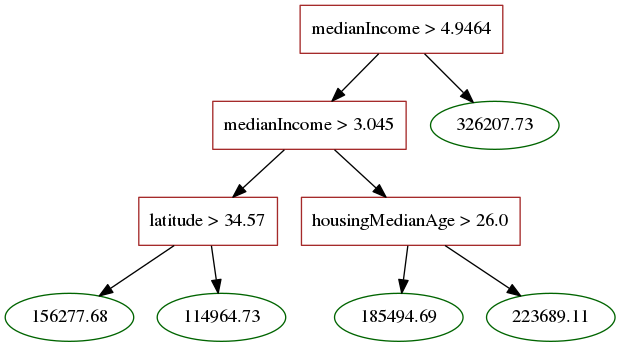

In [6]:
showtree(cahtree, var, "cahtree")
Image(filename="cahtree.png")

Now, get observation predictions and node memberships.

In [32]:
%time leaf = cahtree.getLeafID(data.map(lambda x: x.features))
%time leafval = leaf.zip(data)
## the below would be better but it's not valid from python...
# leafval = data.map(lambda x: (cahtree.getLeafID(x.features), x))

CPU times: user 3.92 ms, sys: 0 ns, total: 3.92 ms
Wall time: 9.13 ms
CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 5.57 ms


In [40]:
# some sanity checks
print leafval.first()
print data.first()
print cahtree.getLeafID(data.first().features)

(3, LabeledPoint(452600.0, [-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252]))
(452600.0,[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252])
3


In [48]:
# we need the groupByKey here for a re-shuffle
branches = leafval.groupByKey()
branches.mapValues(len).glom().collect()


[[(8, 3744), (10, 3649)], [(3, 4614), (9, 3943), (11, 4690)]]

In [95]:
# if your groups are small enough, just use the in-memory speedy scikit learn forests
import numpy as np
import scipy as sp
from sklearn import ensemble

def fitforest(lvi):
    y = [p.label for p in lvi]
    x = np.array([p.features for p in lvi])
    f = ensemble.RandomForestRegressor(n_estimators=100,min_samples_leaf=100)
    f.fit(x, y)
    return f


In [110]:
caf = branches.mapValues(fitforest).collectAsMap()
len(caf)

5

In [125]:
def predforest(key, lvi):
    y = [p.label for p in lvi]
    x = np.array([p.features for p in lvi])
    yhat = caf[key].predict(x).round()
    yy = np.array([y,yhat])
    return yy.T
    


In [126]:
fits = branches.map( lambda p: predforest(p[0],p[1]) ).collect()
fits

[array([[  60800.,   85204.],
        [  53400.,  102625.],
        [  46700.,   91731.],
        ..., 
        [ 176000.,  240620.],
        [ 196400.,  229453.],
        [ 325000.,  232023.]]), array([[ 256100.,  253003.],
        [ 143800.,  244960.],
        [ 228400.,  260350.],
        ..., 
        [ 112000.,  128743.],
        [ 107200.,  127131.],
        [ 115600.,  126561.]]), array([[ 452600.,  460141.],
        [ 358500.,  418952.],
        [ 352100.,  423408.],
        ..., 
        [ 286000.,  257096.],
        [ 165000.,  212686.],
        [ 225000.,  260275.]]), array([[ 226700.,  153341.],
        [ 191300.,  160194.],
        [ 159200.,  153341.],
        ..., 
        [  92300.,   92147.],
        [  84700.,   95014.],
        [  89400.,  107065.]]), array([[ 342200.,  217538.],
        [ 269700.,  217356.],
        [ 299200.,  239107.],
        ..., 
        [ 100000.,  175188.],
        [  72000.,  162963.],
        [ 116800.,  134144.]])]